In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter INFO & WARNING, 3 = only ERROR
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"
#os.environ["XLA_FLAGS"] = "--xla_dump_to=/tmp/xla_logs --xla_dump_hlo_pass=0"
import logging
class XlaFilter(logging.Filter):
    def filter(self, record):
        return "external/local_xla/xla/service/slow_operation_alarm.cc" not in record.msg
logging.getLogger().addFilter(XlaFilter())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
import json
import h5py
import math
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import hamming_loss, precision_recall_fscore_support, accuracy_score

import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.callbacks import LearningRateScheduler
import gc

# Enable mixed precision for faster training (if compatible)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

E0000 00:00:1741228047.375859   11636 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741228047.378977   11636 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#!conda list cudnn

In [5]:
# Function to get total song count with error handling
def get_total_song_count(h5_file_path):
    """Return the list of all song names in the HDF5 file."""
    try:
        with h5py.File(h5_file_path, "r") as f:
            return list(f.keys())
    except Exception as e:
        print(f"Error accessing HDF5 file: {e}")
        return []

In [6]:
class SongSegmentsGenerator:
    def __init__(self, h5_file_path, song_list, shuffle=True, random_seed=42):
        self.h5_file_path = h5_file_path
        self.song_list = song_list
        self.shuffle = shuffle
        self.random_seed = random_seed

    def __iter__(self):
        with h5py.File(self.h5_file_path, "r") as f:
            songs = self.song_list.copy()
            if self.shuffle:
                np.random.seed(self.random_seed)
                np.random.shuffle(songs)
            for song in songs:
                grp = f[song]
                target = grp["target"][:]
                seg_keys = list(grp["segments"].keys())
                for seg_key in seg_keys:
                    try:
                        seg = grp["segments"][seg_key][:]
                        # Normalize to [0, 1], handle flat segments
                        min_seg = np.min(seg)
                        max_seg = np.max(seg)
                        if max_seg == min_seg:  # Flat segment
                            seg = np.zeros_like(seg)  # Zero out instead of NaN
                        else:
                            seg = (seg - min_seg) / (max_seg - min_seg)
                        seg = np.expand_dims(seg, axis=-1)
                        yield (seg.astype(np.float32), target.astype(np.float32))
                    except Exception as e:
                        print(f"Skipping segment {seg_key} in song {song}: {e}")
                        continue

In [7]:
def create_tf_dataset_from_h5(h5_file_path, song_list, batch_size=16, shuffle=True, random_seed=42):
    generator = SongSegmentsGenerator(
        h5_file_path=h5_file_path,
        song_list=song_list,
        shuffle=shuffle,
        random_seed=random_seed
    )
    ds = tf.data.Dataset.from_generator(
        lambda: iter(generator),
        output_signature=(
            tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),  # Individual spectrogram
            tf.TensorSpec(shape=(8,), dtype=tf.float32)             # Individual label
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=random_seed)
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([128, None, 1], [8]),  # Pad time_steps dimension
        padding_values=(0.0, 0.0)             # Pad with zeros
    )
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
# Count batches in epoch
def count_batches_in_epoch(h5_file_path, song_list, batch_size):
    total_segments = 0
    with h5py.File(h5_file_path, "r") as f:
        for song in song_list:
            num_seg = len(list(f[song]["segments"].keys()))
            total_segments += num_seg
    return math.ceil(total_segments / batch_size)

In [9]:
# Stratified train-test split based on genre labels
def stratified_split(h5_file_path, all_songs, test_size=0.2, random_state=42):
    with h5py.File(h5_file_path, "r") as f:
        labels = [f[song]["target"][:] for song in all_songs]
    labels = np.array(labels)
    # Use the first genre for stratification (adjust if necessary)
    stratify_labels = labels[:, 0]
    train_songs, test_songs = train_test_split(all_songs, test_size=test_size, random_state=random_state, stratify=stratify_labels)
    return train_songs, test_songs

In [10]:
# Calculate class weights with label smoothing
def calculate_class_weights(h5_file_path, train_songs):
    all_labels = []
    with h5py.File(h5_file_path, 'r') as f:
        for song in train_songs:
            all_labels.append(f[song]["target"][:])
    all_labels = np.vstack(all_labels)
    class_weights_per_genre = []
    for i in range(all_labels.shape[1]):
        y_genre = all_labels[:, i]
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_genre)
        class_weights_per_genre.append(weights)
    class_weights_per_genre = np.array(class_weights_per_genre, dtype=np.float32)
    class_weights_per_genre[:, 1] *= 2.5  # Adjust multiplier as needed
    return class_weights_per_genre

In [11]:
def weighted_focal_loss(y_true, y_pred_logits, gamma=2.0):
    y_true = tf.cast(y_true, dtype=y_pred_logits.dtype)
    y_pred_logits = tf.clip_by_value(y_pred_logits, -10, 10)  # Prevent overflow
    y_pred = tf.nn.sigmoid(y_pred_logits)
    
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred_logits)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = tf.pow(1 - p_t, gamma)
    focal_bce = focal_weight * bce
    
    batch_size = tf.shape(y_true)[0]
    weights_0 = tf.cast(class_weights_per_genre[:, 0][None, :], dtype=y_pred_logits.dtype)
    weights_1 = tf.cast(class_weights_per_genre[:, 1][None, :], dtype=y_pred_logits.dtype)
    weights_0 = tf.tile(weights_0, [batch_size, 1])
    weights_1 = tf.tile(weights_1, [batch_size, 1])
    weights = tf.where(y_true == 1.0, weights_1, weights_0)
    weighted_focal_bce = focal_bce * weights
    
    # Replace NaN with 0
    weighted_focal_bce = tf.where(tf.math.is_nan(weighted_focal_bce), tf.zeros_like(weighted_focal_bce), weighted_focal_bce)
    
    return tf.cast(tf.reduce_mean(weighted_focal_bce, axis=-1), tf.float32)

# Weighted binary cross-entropy with label smoothing
def weighted_binary_crossentropy(y_true, y_pred_logits):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred_logits)
    batch_size = tf.shape(y_true)[0]
    weights_0 = tf.tile(class_weights_per_genre[:, 0][None, :], [batch_size, 1])
    weights_1 = tf.tile(class_weights_per_genre[:, 1][None, :], [batch_size, 1])
    weights = tf.where(y_true == 1.0, weights_1, weights_0)
    weighted_bce = bce * weights
    return tf.reduce_mean(weighted_bce, axis=-1)

In [12]:
# ExactMatchRatio (from prior message)
class ExactMatchRatio(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.4, name='exact_match_ratio', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total = self.add_weight(name='total', initializer='zeros')
        self.correct = self.add_weight(name='correct', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        matches = tf.reduce_all(tf.equal(y_true, y_pred), axis=-1)
        self.correct.assign_add(tf.reduce_sum(tf.cast(matches, tf.float16)))
        self.total.assign_add(tf.cast(tf.shape(y_true)[0], tf.float16))

    def result(self):
        return self.correct / self.total

    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

In [13]:
# Augment spectrogram with probability
def augment_spectrogram(x, y):
    if tf.random.uniform([]) < 0.5:
        time_shift = tf.random.uniform([], minval=-10, maxval=10, dtype=tf.int32)
        x = tf.roll(x, shift=time_shift, axis=2)
    if tf.random.uniform([]) < 0.5:
        freq_shift = tf.random.uniform([], minval=-5, maxval=5, dtype=tf.int32)
        x = tf.roll(x, shift=freq_shift, axis=1)
    if tf.random.uniform([]) < 0.4:
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.07)
        x = x + noise
    if tf.random.uniform([]) < 0.6:
        x = tf.image.random_brightness(x, max_delta=0.2)
    if tf.random.uniform([]) < 0.5:
        freq_mask = tf.random.uniform([tf.shape(x)[0], tf.shape(x)[1], 1, 1], 0, 1) < 0.94
        x = x * tf.cast(freq_mask, x.dtype)
    if tf.random.uniform([]) < 0.5:
        time_mask = tf.random.uniform([tf.shape(x)[0], 1, tf.shape(x)[2], 1], 0, 1) < 0.94
        x = x * tf.cast(time_mask, x.dtype)
    return x, y

In [14]:
def augment_and_original(x, y):
    augmented_x, _ = augment_spectrogram(x, y)  # Only augment x
    return tf.data.Dataset.from_tensor_slices(([x, augmented_x], [y, y]))

# Create pairs for augmentation
def create_pairs(x, y):
    augmented_x = augment_spectrogram(x)
    return tf.data.Dataset.from_tensor_slices(([x, augmented_x], [y, y]))

In [15]:
# Residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

class CBAMLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define layers for channel attention
        self.dense1 = layers.Dense(input_shape[-1] // 8, activation='relu')
        self.dense2 = layers.Dense(input_shape[-1], activation='sigmoid')
        # Define layer for spatial attention
        self.conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')

    def call(self, x):
        # Channel attention
        avg_pool = layers.GlobalAveragePooling2D()(x)
        max_pool = layers.GlobalMaxPooling2D()(x)
        dense1_avg = self.dense1(avg_pool)
        dense1_max = self.dense1(max_pool)
        dense2_avg = self.dense2(dense1_avg)
        dense2_max = self.dense2(dense1_max)
        channel_attention = layers.Add()([dense2_avg, dense2_max])
        channel_attention = layers.Activation('sigmoid')(channel_attention)
        channel_attention = layers.Multiply()([x, channel_attention])

        # Spatial attention
        avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        spatial_attention = layers.Multiply()([channel_attention, spatial_attention])

        return spatial_attention

In [16]:
# Main pipeline
h5_file_path = "creating_spectrogram_batches/final_data/data_8s.h5"
all_songs = get_total_song_count(h5_file_path)
print("Total songs in HDF5 file:", len(all_songs))

Total songs in HDF5 file: 1023


In [18]:
# Stratified split
train_songs, test_songs = stratified_split(h5_file_path, all_songs, test_size=0.2, random_state=42)
print("Number of training songs:", len(train_songs))
print("Number of testing songs:", len(test_songs))

Number of training songs: 818
Number of testing songs: 205


In [20]:
total_segments = 0
with h5py.File(h5_file_path, "r") as f:
    for song in train_songs:
        total_segments += len(f[song]["segments"].keys())
print("Total 8s segments:", total_segments)  # Should be ~60,480
print("Expected steps:", math.ceil(total_segments / 64) * 2)  # ~1890

Total 8s segments: 41606
Expected steps: 1302


In [21]:
# Calculate class weights
class_weights_per_genre = calculate_class_weights(h5_file_path, train_songs)
print("Adjusted class weights per genre:\n", class_weights_per_genre)

Adjusted class weights per genre:
 [[ 0.8364008   3.1079028 ]
 [ 0.57686883  9.3807335 ]
 [ 0.7316637   3.9478765 ]
 [ 0.6122754   6.8166666 ]
 [ 0.7356115   3.9026716 ]
 [ 0.572028    9.927185  ]
 [ 0.62252665  6.3509316 ]
 [ 0.52234995 29.214287  ]]


In [22]:
class_weights_per_genre[:, 1] *= 2  # Adjust multiplier as needed

In [23]:
# Calculate steps
batch_size = 64
steps_per_epoch = count_batches_in_epoch(h5_file_path, train_songs, batch_size)
validation_steps = count_batches_in_epoch(h5_file_path, test_songs, batch_size)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 651
Validation steps: 164


In [24]:
train_ds = create_tf_dataset_from_h5(h5_file_path, song_list=train_songs, batch_size=batch_size, shuffle=True, random_seed=42)
train_ds = train_ds.flat_map(augment_and_original).repeat()
steps_per_epoch = count_batches_in_epoch(h5_file_path, train_songs, batch_size) * 2

I0000 00:00:1741228402.953800   11636 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [25]:
test_ds = create_tf_dataset_from_h5(h5_file_path, song_list=test_songs, batch_size=batch_size, shuffle=True, random_seed=42)
test_ds = test_ds.repeat()

In [26]:
# Get input shape and number of classes
for X_batch, y_batch in train_ds.take(1):
    input_shape = X_batch.shape[1:]
    num_classes = y_batch.shape[-1]
    break
print(input_shape)

(128, 345, 1)


In [27]:
from tensorflow.keras.optimizers.schedules import CosineDecay

In [28]:
# Learning rate scheduler with cosine decay
lr_scheduler = CosineDecay(initial_learning_rate=1e-4, decay_steps=steps_per_epoch * 50)

# Optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler, clipnorm=1.0)

In [ ]:
# Improved model with CBAM
def model_1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)  # Increased filters
    x = layers.BatchNormalization()(x)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, 512)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)
    x = CBAMLayer()(x)  # Replace cbam_block with CBAMLayer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.45)(x)  # Reduced dropout slightly
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)  # Reduced dropout slightly
    outputs = layers.Dense(num_classes)(x)  # Logits output
    model = models.Model(inputs, outputs)
    return model

In [17]:
# Create and compile model
model_1 = model_1(input_shape, num_classes)
model_1.compile(
    loss=weighted_binary_crossentropy,
    optimizer=optimizer,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(threshold=0.4, average='micro'),
        tf.keras.metrics.F1Score(threshold=0.4, average='macro'),
        ExactMatchRatio(threshold=0.4)
    ]
)
model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 1292, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 1292, │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 1292, │        320 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 1292, │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 1292, │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 1292, │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 1292, │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 1292, │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 1292, │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 1292, │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 1292, │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 646,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 646,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 646,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 646,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 646,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 646,   │      2,112 │ dropout[0][0]   

 Total params: 5,503,467 (20.99 MB)

 Trainable params: 5,497,515 (20.97 MB)

 Non-trainable params: 5,952 (23.25 KB)

In [18]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='exact_match_ratio', mode = 'max', patience=5, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_models/best_model_1.keras', save_best_only=True, monitor='exact_match_ratio', mode='max')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

callbacks = [early_stopping, checkpoint, tensorboard]

In [19]:
# Train the model
history_1 = model_1.fit(
    train_ds,
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/250


I0000 00:00:1741132394.746303   86347 service.cc:148] XLA service 0x7fc2d40591e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741132394.746356   86347 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1741132396.335664   86347 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741132463.128689   86347 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - binary_accuracy: 0.7966 - f1_score: 0.2454 - f1_score_1: 0.1918 - loss: 1.0129 - precision: 0.6202 - recall: 0.1412  

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_f1_score_macro available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 377s 225ms/step - binary_accuracy: 0.7966 - f1_score: 0.2454 - f1_score_1: 0.1919 - loss: 1.0127 - precision: 0.6202 - recall: 0.1413 - val_binary_accuracy: 0.7673 - val_f1_score: 0.2336 - val_f1_score_1: 0.1329 - val_loss: 0.6313 - val_precision: 0.4569 - val_recall: 0.1558
Epoch 2/250
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 162s 127ms/step - binary_accuracy: 0.8316 - f1_score: 0.4574 - f1_score_1: 0.4250 - loss: 0.4936 - precision: 0.7664 - recall: 0.3101 - val_binary_accuracy: 0.7873 - val_f1_score: 0.2542 - val_f1_score_1: 0.2037 - val_loss: 0.4603 - val_precision: 0.6219 - val_recall: 0.1510
Epoch 3/250
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 164s 128ms/step - binary_accuracy: 0.8443 - f1_score: 0.5201 - f1_score_1: 0.4925 - loss: 0.3659 - precision: 0.7935 - recall: 0.3715 - val_binary_accuracy: 0.8141 - val_f1_score: 0.4059 - val_f1_score_1: 0.3417 - val_loss: 0.3553 - val_precision: 0.7531 - val_recall: 0.2643
Epoch 4/250
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 163s 128ms/s

In [35]:
def evaluate_metrics(model, dataset, steps, threshold=0.5):
    y_true_all, y_pred_all = [], []
    for x, y in dataset.take(steps):
        y_pred = model.predict(x, verbose=0)  # Probabilities (logits passed through sigmoid)
        y_pred = (y_pred > threshold).astype(int)  # Apply new threshold
        y_true_all.extend(y.numpy())
        y_pred_all.extend(y_pred)
    hamming = hamming_loss(y_true_all, y_pred_all)
    precision_mo, recall_mo, f1_mo, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average='micro')
    precision_ma, recall_ma, f1_ma, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average='macro')
    exact_match = accuracy_score(y_true_all, y_pred_all)
    _, _, class_f1, support = precision_recall_fscore_support(y_true_all, y_pred_all, average=None)
    return hamming, precision_mo, recall_mo, f1_mo, precision_ma, recall_ma, f1_ma, exact_match, class_f1, support

In [21]:
hamming, precision_mo, recall_mo, f1_mo, precision_ma, recall_ma, f1_ma, exact, class_f1, support = evaluate_metrics(model_1, test_ds, validation_steps, threshold=0.4)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Micro Precision: {precision_mo:.4f}, Recall: {recall_mo:.4f}, F1: {f1_mo:.4f}")
print(f"Macro Precision: {precision_ma:.4f}, Recall: {recall_ma:.4f}, F1: {f1_ma:.4f}")
print(f"Exact Match Ratio: {exact:.4f}")
print("Per-class F1 scores:", class_f1)
print("Support per class:", support)

Hamming Loss: 0.1575
Micro Precision: 0.6846, Recall: 0.5625, F1: 0.6176
Macro Precision: 0.6860, Recall: 0.5435, F1: 0.5963
Exact Match Ratio: 0.2584
Per-class F1 scores: [0.7977208  0.50777202 0.57934858 0.6485623  0.61547344 0.49521531
 0.42250287 0.7037037 ]
Support per class: [925 266 871 737 846 398 506 112]


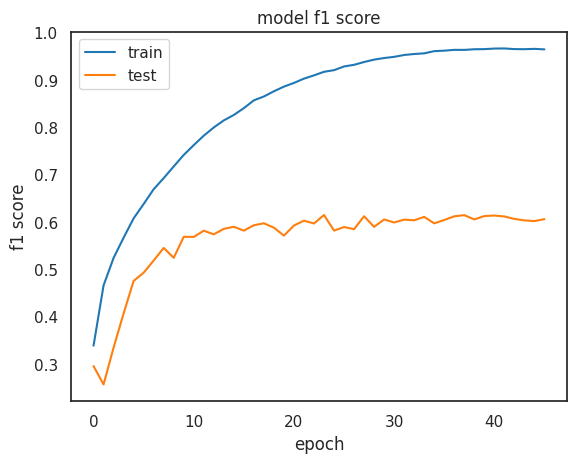

In [25]:
# summarize history for accuracy
plt.plot(history_1.history['f1_score'])
plt.plot(history_1.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history_dict = history_1.history
Accuracy = history_dict['binary_accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
gc.collect()

14

In [29]:
def model_2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)  # Increased filters
    x = layers.BatchNormalization()(x)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, 512)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)
    x = CBAMLayer()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002))(x)
    x = layers.Dropout(0.45)(x)  # Reduced dropout slightly
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0015))(x)
    x = layers.Dropout(0.2)(x)  # Reduced dropout slightly
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0008))(x)
    x = layers.Dropout(0.1)(x)  # Reduced dropout slightly
    outputs = layers.Dense(num_classes)(x)  # Logits output
    model = models.Model(inputs, outputs)
    return model

In [30]:
# Create and compile model
model_2 = model_2(input_shape, num_classes)
model_2.compile(
    loss=weighted_focal_loss,
    optimizer=optimizer,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(threshold=0.45, average='micro'),
        tf.keras.metrics.F1Score(threshold=0.45, average='macro'),
        ExactMatchRatio(threshold=0.4, name='exact_match_ratio')
    ]
)
model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 345,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 345,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 345,  │        320 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 345,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 345,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 345,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 345,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 345,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 345,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 345,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 345,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 172,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 172,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 172,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 172,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 172,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 172,   │      2,112 │ dropout[0][0]   

 Total params: 5,401,963 (20.61 MB)

 Trainable params: 5,396,011 (20.58 MB)

 Non-trainable params: 5,952 (23.25 KB)

In [31]:
for x, y in train_ds.take(1):
    logits = model_2(x, training=False)
    loss = weighted_focal_loss(y, logits)
    print("Focal Loss Sample:", loss.numpy())

I0000 00:00:1741228430.935909   11636 cuda_dnn.cc:529] Loaded cuDNN version 90300


Focal Loss Sample: [1.3769531  0.2668457  0.38134766 0.65722656 1.8095703  0.38134766
 1.3769531  0.2668457  0.38085938 0.5205078  0.5517578  0.22802734
 0.38110352 0.2668457  0.65722656 0.38134766 0.65722656 0.38256836
 0.52001953 0.6567383  0.38256836 0.63671875 1.8095703  0.65722656
 0.5185547  0.55126953 1.8095703  0.65722656 0.38110352 0.55126953
 0.38110352 0.55126953 0.52001953 0.63623047 1.3769531  0.3828125
 0.22802734 0.2668457  0.6567383  0.5175781  1.0878906  1.0898438
 0.65722656 0.3828125  0.38134766 0.26538086 0.2277832  0.5185547
 0.38134766 0.65722656 0.52001953 0.2668457  0.2668457  0.5175781
 1.8095703  1.8095703  0.52001953 0.26538086 0.6352539  0.38110352
 0.55126953 0.22802734 0.5205078  0.38134766]


In [32]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_exact_match_ratio', mode = 'max', patience=25, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_models/best_model_2.keras', save_best_only=True, monitor='val_exact_match_ratio', mode='max')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

callbacks = [early_stopping, checkpoint, tensorboard]

In [33]:
# Train the model
history_2 = model_2.fit(
    train_ds,
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/250


I0000 00:00:1741228447.188063   11840 service.cc:148] XLA service 0x7fad3c003950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741228447.188096   11840 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1741228501.071447   11840 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1302/1302 ━━━━━━━━━━━━━━━━━━━━ 383s 243ms/step - binary_accuracy: 0.6215 - exact_match_ratio: 0.0147 - f1_score: 0.4408 - f1_score_1: 0.4137 - loss: 1.4863 - precision: 0.3256 - recall: 0.6871 - val_binary_accuracy: 0.5193 - val_exact_match_ratio: 0.0073 - val_f1_score: 0.3170 - val_f1_score_1: 0.2542 - val_loss: 0.7326 - val_precision: 0.2286 - val_recall: 0.5024
Epoch 2/250
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 185s 142ms/step - binary_accuracy: 0.7153 - exact_match_ratio: 0.0427 - f1_score: 0.5479 - f1_score_1: 0.5256 - loss: 0.5252 - precision: 0.4203 - recall: 0.8091 - val_binary_accuracy: 0.5639 - val_exact_match_ratio: 0.0044 - val_f1_score: 0.3905 - val_f1_score_1: 0.3811 - val_loss: 0.4697 - val_precision: 0.2803 - val_recall: 0.6307
Epoch 3/250
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 186s 143ms/step - binary_accuracy: 0.7360 - exact_match_ratio: 0.0540 - f1_score: 0.5712 - f1_score_1: 0.5513 - loss: 0.3444 - precision: 0.4433 - recall: 0.8269 - val_binary_accuracy: 0.6001 - val_exact_match_r

In [ ]:
model_2.save('saved_models/model_2.keras')

In [36]:
# Run evaluation
hamming, precision_mo, recall_mo, f1_mo, precision_ma, recall_ma, f1_ma, exact, class_f1, support = evaluate_metrics(model_2, test_ds, validation_steps, threshold=0.5)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Micro Precision: {precision_mo:.4f}, Recall: {recall_mo:.4f}, F1: {f1_mo:.4f}")
print(f"Macro Precision: {precision_ma:.4f}, Recall: {recall_ma:.4f}, F1: {f1_ma:.4f}")
print(f"Exact Match Ratio: {exact:.4f}")
print("Per-class F1 scores:", class_f1)
print("Support per class:", support)

Hamming Loss: 0.2103
Micro Precision: 0.5145, Recall: 0.7240, F1: 0.6015
Macro Precision: 0.5508, Recall: 0.6938, F1: 0.5984
Exact Match Ratio: 0.1691
Per-class F1 scores: [0.76045241 0.59188783 0.59470305 0.59110527 0.57967844 0.49079522
 0.53606172 0.64214047]
Support per class: [3828 1078 3135 2121 3439 1665 2432  680]


In [ ]:
# summarize history for accuracy
plt.plot(history_2.history['f1_score'])
plt.plot(history_2.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history_dict = history_2.history
Accuracy = history_dict['binary_accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model 80% acc, 82% test acc, loss 0.61
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Loads the weights
model_best.load_weights('best_model.h5')

# Re-evaluate the model
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [17]:
gc.collect()

1069

In [18]:
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)